[1] sapla.jpg  |  padded size: (128, 128)
 DFT: 0.0026s | FFT: 0.001713s | Speedup: 1.5126x
[2] sapla.png  |  padded size: (128, 128)
 DFT: 0.0027s | FFT: 0.001850s | Speedup: 1.4607x


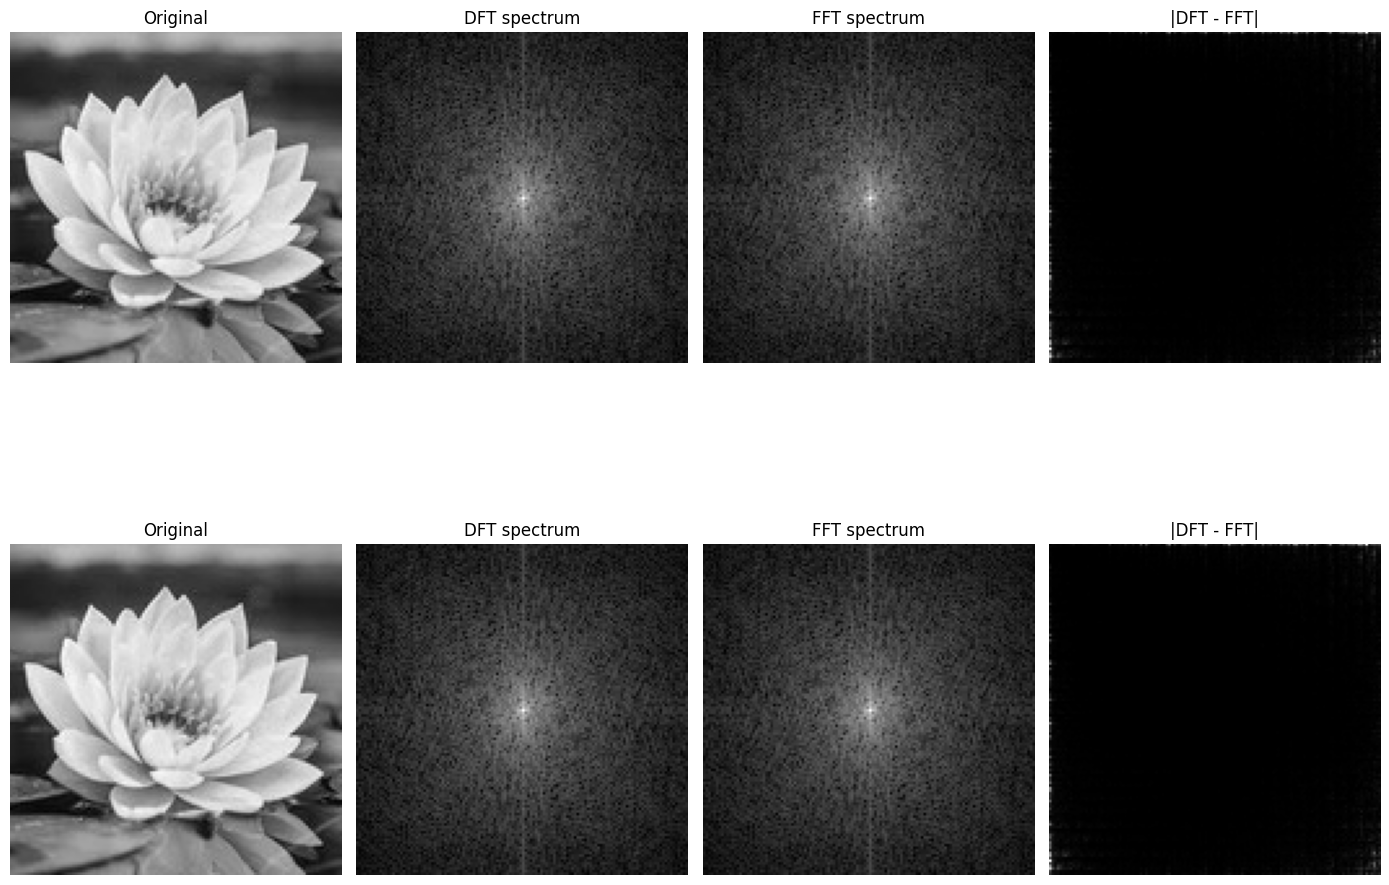

In [7]:
# -*- coding: utf-8 -*-
"""
Digital Image Processing Assignment
-----------------------------------
DFT vs FFT (from scratch) Implementation in Python

This script:
1. Loads grayscale images.
2. Computes DFT and FFT manually (no np.fft).
3. Compares runtime and accuracy.
4. Displays original, DFT spectrum, FFT spectrum, and difference map.
"""

#------------------------imports----------------#
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#------------------------config----------------#
IMAGES = [
    "sapla.jpg",
    "sapla.png",
]
MAX_DIM = 128  # resize max dimension for faster computation

#------------------------helpers----------------#
def load_gray(path):
    """Load image as grayscale [0,1]."""
    img = Image.open(path).convert("L")
    return np.asarray(img, dtype=np.float32) / 255.0

def resize_max_dim(a, max_dim=128):
    """Resize while keeping aspect ratio; ensure max(H, W) <= max_dim."""
    h, w = a.shape
    if max(h, w) <= max_dim:
        return a
    s = max_dim / float(max(h, w))
    nh, nw = max(1, int(round(h * s))), max(1, int(round(w * s)))
    img = Image.fromarray((a * 255).astype(np.uint8), mode="L").resize((nw, nh), Image.BICUBIC)
    return np.asarray(img, dtype=np.float32) / 255.0

def next_pow2(n):
    """Find next power of 2."""
    return 1 << (n - 1).bit_length()

def pad_to_pow2(img):
    """Zero-pad to power-of-two shape for FFT."""
    h, w = img.shape
    H, W = next_pow2(h), next_pow2(w)
    out = np.zeros((H, W), dtype=img.dtype)
    out[:h, :w] = img
    return out

#------------------------DFT (from general equation)----------------#
def dft_matrix(N):
    """Compute DFT matrix."""
    n = np.arange(N)
    k = n.reshape((N, 1))
    return np.exp(-2j * np.pi * k * n / N)

def dft2(img):
    """2D DFT using separability: F = W_H @ img @ W_W^T"""
    H, W = img.shape
    WH = dft_matrix(H)
    WW = dft_matrix(W)
    return WH @ img @ WW.T

#------------------------FFT (from-scratch, vectorized)----------------#
def _is_pow2(n):
    return n > 0 and (n & (n - 1)) == 0

def _bitrev_indices(N):
    bits = int(np.log2(N))
    i = np.arange(N, dtype=np.uint32)
    j = np.zeros_like(i)
    for b in range(bits):
        j |= ((i >> b) & 1) << (bits - 1 - b)
    return j.astype(int)

def fft2_scratch(img):
    """Fully vectorized radix-2 2D FFT (no np.fft)."""
    Z = np.asarray(img, dtype=np.complex128).copy()
    M, N = Z.shape

    # ----- rows (axis=1) -----
    if _is_pow2(N):
        Z = Z[:, _bitrev_indices(N)]
        m = 2
        while m <= N:
            half = m // 2
            tw = np.exp(-2j * np.pi * np.arange(half) / m)
            G = Z.reshape(M, N // m, m)
            U = G[:, :, :half].copy()
            V = G[:, :, half:]
            T = V * tw[None, None, :]
            G[:, :, :half] = U + T
            G[:, :, half:] = U - T
            m *= 2
    else:
        WN = dft_matrix(N)
        Z = (WN @ Z.T).T

    # ----- cols (axis=0) -----
    M, N = Z.shape
    if _is_pow2(M):
        Z = Z[_bitrev_indices(M), :]
        m = 2
        while m <= M:
            half = m // 2
            tw = np.exp(-2j * np.pi * np.arange(half) / m)
            G = Z.reshape(M // m, m, N)
            U = G[:, :half, :].copy()
            V = G[:, half:, :]
            T = tw[None, :, None] * V
            G[:, :half, :] = U + T
            G[:, half:, :] = U - T
            m *= 2
    else:
        WM = dft_matrix(M)
        Z = WM @ Z

    return Z

def fftshift_scratch(X):
    """Center shift (zero-frequency to center)."""
    M, N = X.shape
    return np.roll(np.roll(X, M // 2, axis=0), N // 2, axis=1)

#------------------------viz----------------#
def spectrum(F):
    """Log-magnitude spectrum normalized to [0,1]."""
    S = np.log1p(np.abs(F))
    S /= (S.max() + 1e-12)
    return S

#------------------------main----------------#
def main(max_dim=MAX_DIM):
    fig, axes = plt.subplots(len(IMAGES), 4, figsize=(14, 6 * len(IMAGES)))
    if len(IMAGES) == 1:
        axes = np.array([axes])  # handle single-row case

    for i, path in enumerate(IMAGES):
        img = load_gray(path)
        img = resize_max_dim(img, max_dim=max_dim)
        img_p = pad_to_pow2(img)
        print(f"[{i+1}] {path}  |  padded size: {img_p.shape}")

        #------------------------DFT----------------#
        t0 = time.perf_counter()
        F_dft = dft2(img_p)
        t1 = time.perf_counter()

        #------------------------FFT----------------#
        t2 = time.perf_counter()
        F_fft = fft2_scratch(img_p)
        t3 = time.perf_counter()

        dft_time = t1 - t0
        fft_time = t3 - t2
        speedup  = (dft_time / fft_time) if fft_time > 0 else float("inf")
        print(f" DFT: {dft_time:.4f}s | FFT: {fft_time:.6f}s | Speedup: {speedup:.4f}x")

        #------------------------visualize----------------#
        S_dft = spectrum(fftshift_scratch(F_dft))
        S_fft = spectrum(fftshift_scratch(F_fft))
        D = np.log1p(np.abs(F_dft - F_fft))
        D /= (D.max() + 1e-12)

        axes[i, 0].imshow(img, cmap="gray");   axes[i, 0].set_title("Original");         axes[i, 0].axis("off")
        axes[i, 1].imshow(S_dft, cmap="gray"); axes[i, 1].set_title("DFT spectrum");     axes[i, 1].axis("off")
        axes[i, 2].imshow(S_fft, cmap="gray"); axes[i, 2].set_title("FFT spectrum");     axes[i, 2].axis("off")
        axes[i, 3].imshow(D, cmap="gray");     axes[i, 3].set_title("|DFT - FFT|");      axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

#------------------------entry_point----------------#
if __name__ == "__main__":
    main()


In [6]:
from google.colab import files

# Upload images manually
uploaded = files.upload()
print("Uploaded files:", list(uploaded.keys()))


Saving sapla.png to sapla.png
Uploaded files: ['sapla.png']
